In [ ]:
import Pkg
Pkg.add("PrettyTables")

In [1]:
using DataFrames, FredData, XLSX, SHA, Dates, CSV, TimeSeries, StatsBase, HiddenMarkovModels, Distributions, Plots, PrettyTables

In [2]:
function guess_init(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios)
    return regimes_probs/sum(regimes_probs)
end

function guess_tmatrix(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios,n_scenarios)
    return regimes_probs ./ sum(regimes_probs,dims=2)
end

function guess_distribution()
    sigma = rand(Uniform(0,0.25))
    means = rand(Uniform(-0.25,0.25))
    return Normal(means,sigma)
end

function train_hmm(data, n_scenarios = 2)

    function guess_distribution()
        sigma = rand(Uniform(0,0.25))
        means = rand(Uniform(-0.25,0.25))
        return Normal(means,sigma)
    end
    
    init_guess = guess_init(n_scenarios)
    guess_matrix = guess_tmatrix(n_scenarios)
    guess_dist = [guess_distribution() for s in 1:n_scenarios]
    hmm_guess = HMM(init_guess, guess_matrix, guess_dist);
    return hmm_est, loglikelihood_evolution = baum_welch(hmm_guess, data);
end 

train_hmm (generic function with 2 methods)

In [3]:
function regime_summary(loglikehood,hmm_est, freq = 1)
        tm = transition_matrix(hmm_est)
        
   return DataFrame(Dict(
      "mu1" => mean(obs_distributions(hmm_est)[1]) * freq,
      "sig1" => std(obs_distributions(hmm_est)[1]) *  freq^0.5,
      "mu2" => mean(obs_distributions(hmm_est)[2]) * freq,
      "sig2" => std(obs_distributions(hmm_est)[2]) * freq^0.5,       
      "p11" =>  tm[1,1],
      "p21" =>  tm[2,1],
      "loglikehood" => last(loglikehood),
      "prob1" =>  tm[2,1]/(tm[1,2]+tm[2,1])
      
  )) 
  end

regime_summary (generic function with 2 methods)

In [4]:
function regime_summary_2(loglikehood,hmm_est, freq = 1)
    tm = transition_matrix(hmm_est),
    n_regimes = length(initialization(hmm_est))
    dict = Dict()
   
    return n_regimes
      
end


regime_summary_2 (generic function with 2 methods)

In [5]:
source_data = TimeArray(CSV.File("assets_data_03.24.csv", delim=';', dateformat=Dict("Date" => "dd.mm.yyyy"), decimal=','),timestamp=:Date)
returns = percentchange(source_data, :log)

615×8 TimeArray{Union{Missing, Float64}, 2, Date, Matrix{Union{Missing, Float64}}} 1973-01-31 to 2024-03-31
┌────────────┬────────────┬─────────────┬──────────────┬──────────────┬─────────
│            │ ACWI_Net   │ USDPLN      │ ACWI_Net_PLN │ CPI_USA      │ CPI_PL ⋯
├────────────┼────────────┼─────────────┼──────────────┼──────────────┼─────────
│ 1973-01-31 │    missing │     missing │      missing │   0.00235067 │     mi ⋯
│ 1973-02-28 │    missing │     missing │      missing │   0.00701905 │     mi ⋯
│ 1973-03-31 │    missing │     missing │      missing │   0.00927727 │     mi ⋯
│ 1973-04-30 │    missing │     missing │      missing │   0.00690598 │     mi ⋯
│ 1973-05-31 │    missing │     missing │      missing │   0.00685862 │     mi ⋯
│ 1973-06-30 │    missing │     missing │      missing │    0.0068119 │     mi ⋯
│ 1973-07-31 │    missing │     missing │      missing │   0.00225501 │     mi ⋯
│ 1973-08-31 │    missing │     missing │      missing │    0.0179014 │     mi ⋯
│

In [6]:
stats = summarystats.(eachcol(values(returns)))

stats = DataFrame([stats[1],stats[2],stats[3]])


Row,mean,sd,min,q25,median,q75,max,nobs,nmiss
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,0.00622469,0.0443616,-0.220834,-0.0181497,0.0124942,0.0330787,0.116238,615,180
2,0.000397277,0.0371301,-0.094026,-0.0247304,-0.00190905,0.0234364,0.166496,615,300
3,0.00581535,0.0380711,-0.111985,-0.0159863,0.00790446,0.0323534,0.105947,615,300


In [7]:
acwi_long = identity.(values(from(returns[:ACWI_Net,],Date(1988,01,01))))
hmm_est, loglikehood = train_hmm(acwi_long,2)
println("ACWI long 2")
regime_summary(loglikehood,hmm_est,12)

ACWI long 2


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,774.685,-0.0115891,0.160694,0.941947,0.0597985,0.507406,0.195717,0.0873582


In [8]:
hmm_est, loglikehood = train_hmm(acwi_long,4)
println("ACWI long 4")
regime_summary(loglikehood,hmm_est,12)

ACWI long 4


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,792.275,0.00966078,-0.58365,0.731321,2.92199e-12,1.73159e-11,0.125914,0.193704


In [9]:
acwi_98 = identity.(values(from(returns[:ACWI_Net],Date(1998,01,01))))
hmm_est, loglikehood = train_hmm(acwi_98,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,519.711,0.0650168,1.38937,1.0,1.0,1.0,0.160998,0.00479858


In [10]:
acwi_03 = identity.(values(from(returns[:ACWI_Net],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(acwi_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,459.165,0.168605,-0.0133086,0.937791,0.0806326,0.564488,0.081276,0.210605


In [11]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_PLN],Date(1998,01,01))))
println("mean $(mean(acwi_pln_98)*12), std: $(std(acwi_pln_98)*12^0.5)")
hmm_est_98_PLN, loglikehood = train_hmm(acwi_pln_98,2)
regime_summary(loglikehood,hmm_est_98_PLN,1)

mean 0.06978414756872021, std: 0.13188218245803085


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,597.333,-0.0742104,0.0125274,0.313141,0.0578082,0.0776296,0.0217522,0.0307265


In [12]:
acwi_pln_01 = identity.(values(from(returns[:ACWI_Net_PLN],Date(2001,01,01))))
hmm_est, loglikehood = train_hmm(acwi_pln_01,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,528.361,0.187226,0.00502263,0.241157,0.326355,0.300733,0.0703654,0.144556


In [13]:
acwi_pln_03 = identity.(values(from(returns[:ACWI_Net_PLN],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(acwi_pln_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,508.991,0.139972,-0.0971908,0.960506,0.138809,0.778501,0.0914573,0.181758


In [80]:
usdpln_03 = identity.(values(from(returns[:USDPLN ],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(usdpln_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,484.829,0.117695,-0.0247196,0.968316,0.00738524,0.18903,0.210459,0.106832


In [15]:
function guess_init(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios)
    return regimes_probs/sum(regimes_probs)
end

function guess_tmatrix(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios,n_scenarios)
    return regimes_probs ./ sum(regimes_probs,dims=2)
end

function guess_distribution()
    corr = Matrix(1.0I,2,2)
    sigma = [rand(Uniform(0,0.25)),rand(Uniform(0,0.035))]
    means = [rand(Uniform(-0.5,0.5)),rand(Uniform(-0.01,0.12))]
    cov = cor2cov(corr,sigma)
    return MvNormal(means,cov)
end

using LinearAlgebra

In [16]:
acwi_and_pln = identity.(values(from(returns[:ACWI_Net_PLN, :USDPLN],Date(2001,01,01))))
n_scenarios = 2


init_guess = guess_init(n_scenarios)
guess_matrix = guess_tmatrix(n_scenarios)
guess_dist = [guess_distribution() for s in 1:n_scenarios]
hmm_guess = HMM(init_guess, guess_matrix, guess_dist);
println(hmm_guess)
hmm_est_concat, _ = baum_welch(hmm_guess, eachrow(acwi_and_pln));

Hidden Markov Model with:
 - initialization: [0.3900709219858156, 0.6099290780141844]
 - transition matrix: [0.30666666666666664 0.6933333333333334; 0.6190476190476191 0.38095238095238093]
 - observation distributions: [FullNormal(
dim: 2
μ: [0.41175773021807727, 0.08669056658929465]
Σ: [0.046529395647990086 0.0; 0.0 8.75278671662059e-6]
)
, FullNormal(
dim: 2
μ: [0.3314796220138376, 0.025601541511439632]
Σ: [0.01506090520011975 0.0; 0.0 6.03174518479935e-8]
)
]


In [17]:
dist1 = obs_distributions(hmm_est_concat)[1]
dist2 = obs_distributions(hmm_est_concat)[2]

mean1 = mean(dist1) .* 12
mean2 = mean(dist2) .* 12

std1 = sqrt.(var(dist1)) .* 12^0.5
std2 = sqrt.(var(dist2)) .* 12^0.5
display("means")
display([mean1 mean2])
display("std")
display([std1 std2])
display("corr")
cor1 = cor(dist1)
display(cor1)
cor2 = cor(dist2)
display(cor2)


"means"

2×2 Matrix{Float64}:
  0.0539861   0.376852
 -0.00784242  0.320808

"std"

2×2 Matrix{Float64}:
 0.129385  0.0588161
 0.130864  0.00170971

"corr"

2×2 Matrix{Float64}:
 1.0       0.225581
 0.225581  1.0

2×2 Matrix{Float64}:
  1.0       -0.337788
 -0.337788   1.0

In [18]:
acwi_short = identity.(values(from(returns[:ACWI_Net],Date(2001,01,01))))
hmm_est, loglikehood = train_hmm(acwi_short,2)
obs_distributions(hmm_est)

2-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=-0.00313697550879231, σ=0.05934995385386742)
 Normal{Float64}(μ=0.013892284866271483, σ=0.023421380935733985)

In [19]:
acwi_short = identity.(from(returns[:ACWI_Net],Date(2001,01,01)))
hmm_est, loglikehood = train_hmm(values(acwi_short),2)
HMM(initialization(hmm_est), transition_matrix(hmm_est), obs_distributions(hmm_est))
states,_ = viterbi(hmm_est,values(acwi_short))
states = Float64.(states)

279-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [20]:
acwi_states = merge(acwi_short,identity.(from((returns[:USDPLN]),Date(1998,01,01))),TimeArray(timestamp(acwi_short),states))
CSV.write("states",acwi_states)


"states"

In [21]:
first_regime = acwi_states[findwhen(acwi_states[:A] .== 1.0)]
second_regime = acwi_states[findwhen(acwi_states[:A] .== 2.0)]

println("First usd pln")
println(mean(values(first_regime[:USDPLN]))*12)
println(std(values(first_regime[:USDPLN]))*12^0.5)
println(cor(values(first_regime[:USDPLN]),values(first_regime[:ACWI_Net ])))

println("Second usd pln")
println(mean(values(second_regime[:USDPLN]))*12)
println(std(values(second_regime[:USDPLN]))*12^0.5)
println(cor(values(second_regime[:USDPLN]),values(second_regime[:ACWI_Net])))

First usd pln
0.02323905518920558
0.14920806835446282
-0.6632535242025056
Second usd pln
-0.02979151262801521
0.10498902329177802
-0.5525433853025217


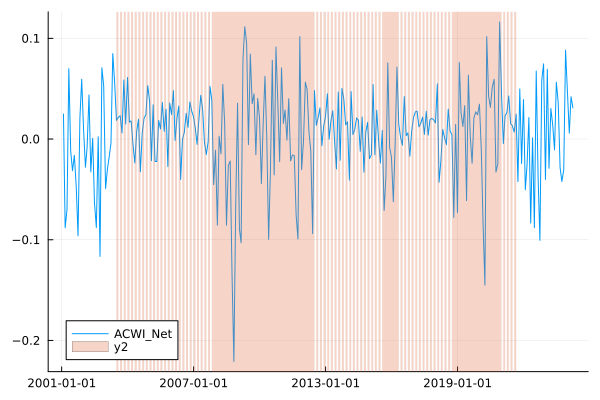

In [22]:
plot(acwi_states[:ACWI_Net ])
vspan!(findwhen(acwi_states[:A] .== 2.0),alpha = 0.3)

In [23]:
sims = [0.06 0.13 -0.23 0.3 -0.05 0.15; 0.15 -0.23 0.06 0.13 0.3 -0.05; -0.05 0.3 -0.23 0.15 0.06 0.13]

function annualise(scenarios:: Matrix, shift=2)
   
    periods = floor.(Int, size(scenarios)[2]/shift)
    result = zeros(size(scenarios)[1],periods)

    for p in 1:periods
        start = (p-1)*shift+1
        en = p*shift
        result[:,p] .= sum(scenarios[:,start:en],dims=2)
    end 
    return result
   
end

annualise(sims,2)


3×3 Matrix{Float64}:
  0.19   0.07  0.1
 -0.08   0.19  0.25
  0.25  -0.08  0.19

In [24]:
function annualise(scenarios:: Vector, shift=2)
   
    periods = floor.(Int, size(scenarios)[1]/shift)
    result = zeros(periods)

    for p in 1:periods
        start = (p-1)*shift+1
        en = p*shift
        result[p] = sum(scenarios[start:en])
    end  
    return result
   
end

annualise(sims[1,:],2)

3-element Vector{Float64}:
 0.19
 0.06999999999999998
 0.09999999999999999

In [25]:
function print_percentiles(X, perc)
    years = size(X)[2]
    simulation_perc = zeros(length(perc),years)

    for t in 1:years
        simulation_perc[:,t] = quantile(X[:,t],perc)
    end
    pretty_table(simulation_perc, backend = Val(:html),header=1:years, row_labels=perc)
end

print_percentiles (generic function with 1 method)

In [26]:
using ScenTrees, SDDP

In [214]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_PLN ],Date(1998,01,01))))
println("mean $(mean(acwi_pln_98)*12)")
println("std $(std(acwi_pln_98)*12^0.5)")

mean 0.06978414756872021
std 0.13188218245803085


In [217]:
println("mean: ",expm1(0.0698))
println("std: ",expm1(0.1319))

mean: 0.07229370106669933
std: 0.14099421414065977


In [216]:
println("mean $(mean(acwi_pln_98))")
println("std $(std(acwi_pln_98))")

mean 0.005815345630726685
std 0.03807110677172973


In [218]:
println("mean: ",expm1(0.0058))
println("std: ",expm1(0.0380))

mean: 0.005816852565873483
std: 0.03873123287849773


In [222]:
years = 15
n_steps = years * 12
n_scenarios = 100000
simulations = rand(Normal(0.0058,0.0387),(n_scenarios,n_steps))
simulations_ann = annualise(simulations,12)

print_percentiles(simulations_ann,[0.01, 0.025,0.16,0.5,0.84,0.975, 0.99])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.01,-0.242263,-0.241252,-0.243898,-0.241907,-0.241797,-0.240418,-0.242734,-0.241739,-0.242553,-0.242756,-0.241226,-0.246095,-0.241151,-0.240549,-0.241392
0.025,-0.192598,-0.191889,-0.194288,-0.193468,-0.192389,-0.192947,-0.192968,-0.193758,-0.193496,-0.19254,-0.192972,-0.194956,-0.191345,-0.191428,-0.191686
0.16,-0.0646758,-0.0638414,-0.0638717,-0.0629254,-0.0633886,-0.0643428,-0.0634294,-0.0638255,-0.0629669,-0.0637367,-0.0632063,-0.0640455,-0.0626969,-0.063711,-0.063556
0.5,0.0691804,0.069407,0.068372,0.0696351,0.0696961,0.068569,0.0694812,0.0695756,0.0688288,0.0708483,0.0702074,0.069429,0.0702847,0.0692261,0.0698611
0.84,0.203019,0.202339,0.201969,0.203395,0.202266,0.202404,0.201667,0.202817,0.204013,0.203251,0.203109,0.203876,0.202175,0.203388,0.203163
0.975,0.331213,0.332671,0.333709,0.333128,0.332908,0.333381,0.332186,0.333172,0.333861,0.330844,0.333536,0.332929,0.331121,0.330731,0.33414
0.99,0.379759,0.381857,0.384321,0.381441,0.381944,0.379885,0.382759,0.384661,0.382828,0.380327,0.382348,0.383601,0.380041,0.378478,0.3834


In [223]:
norm_moments = Dict(
    :mean => mean(simulations[:,1]),
    :min => minimum(simulations[:,1]),
    :max => maximum(simulations[:,1]),
    :median => median(simulations[:,1]),
    :std => std(simulations[:,1]),
    :var => var(simulations[:,1]),
    :skew => skewness(simulations[:,1]),
    :kurtosis => kurtosis(simulations[:,1])  
)

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.16813
  :median   => 0.00545897
  :std      => 0.0388241
  :mean     => 0.00549482
  :var      => 0.00150731
  :kurtosis => 0.0115107
  :skew     => 0.00248777
  :min      => -0.161096

In [224]:
print_percentiles(annualise(simulations,60),[.1, .3, .5, .7, .9]) 

,1,2,3
0.1,-0.0361047,-0.0361562,-0.0352456
0.3,0.190979,0.190499,0.191878
0.5,0.346292,0.348219,0.349382
0.7,0.503808,0.505497,0.506031
0.9,0.72978,0.734294,0.733035


In [83]:
function simulator()
    scenarios = rand(Normal(0.0723,0.1410),180)
    return scenarios #annualise(scenarios,12)
end

graph = SDDP.MarkovianGraph(simulator; budget = fill(5,15), scenarios = 100000);
graph


Root
 (0, 0.0)
Nodes
 (1, -0.08854756114927403)
 (1, 0.04774948378041916)
 (1, 0.07789787606299874)
 (1, 0.18453690919016388)
 (1, 0.3934009093824541)
 (2, -0.09076075219240398)
 (2, -0.005360072832848097)
 (2, 0.0751811565543704)
 (2, 0.18284343451613974)
 (2, 0.3890363617783442)
 (3, -0.15326815645658168)
 (3, -0.022461417553311883)
 (3, 0.07326560026106714)
 (3, 0.18214544271119296)
 (3, 0.38869966781386545)
 (4, -0.09165092153834703)
 (4, 0.012358079469855367)
 (4, 0.07658170314808321)
 (4, 0.18274379761335502)
 (4, 0.3902268252359028)
 (5, -0.08906074907968893)
 (5, 0.03264561330925338)
 (5, 0.0770263082754935)
 (5, 0.18309996900416092)
 (5, 0.3884821004207399)
 (6, -0.08925381892266011)
 (6, 0.025645244144043716)
 (6, 0.076326505339791)
 (6, 0.1833289754442842)
 (6, 0.38877411628649305)
 (7, -0.14239896057005308)
 (7, -0.02262539210925512)
 (7, 0.07323189397251445)
 (7, 0.18175557641749954)
 (7, 0.3869861246225201)
 (8, -0.0853528844294267)
 (8, 0.06307214385379989)
 (8, 0.085528

In [200]:
years = 15
n_steps = years*12
n_scenarios = 5000

hmm = HMM([1.,0],[0.95 0.05; 0.124529 0.875471],[Normal(0.0134,0.0277),Normal(-0.0134,0.0515)])
simulations = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    simulations[s,:] .= rand(hmm,n_steps)[2]
end

simulations_ann = annualise(simulations,12)

print_percentiles(simulations_ann,[0.01, 0.025,0.16,0.5,0.84,0.975, 0.99])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.01,-0.300397,-0.403072,-0.38254,-0.388976,-0.427381,-0.405843,-0.396904,-0.403387,-0.393931,-0.398606,-0.410657,-0.417041,-0.412188,-0.373583,-0.413196
0.025,-0.223409,-0.30674,-0.307441,-0.313403,-0.324028,-0.320646,-0.320938,-0.317096,-0.310678,-0.319924,-0.321655,-0.325085,-0.324271,-0.30723,-0.33756
0.16,-0.0181015,-0.0862417,-0.0872449,-0.0932284,-0.0970227,-0.0919599,-0.0874344,-0.0902573,-0.092822,-0.0932892,-0.0809036,-0.0809032,-0.080926,-0.088808,-0.0929473
0.5,0.124876,0.0946995,0.0994194,0.0928247,0.0930483,0.0934844,0.0989188,0.0967269,0.0963968,0.0936012,0.0932267,0.0944469,0.0965281,0.0937404,0.0933746
0.84,0.239818,0.223353,0.225772,0.222507,0.216346,0.221088,0.226282,0.220914,0.222534,0.221948,0.220534,0.22294,0.220299,0.22054,0.220957
0.975,0.337025,0.330867,0.330962,0.33656,0.326155,0.326119,0.332468,0.326768,0.333003,0.32883,0.322639,0.331948,0.326642,0.328393,0.323192
0.99,0.371148,0.377049,0.371872,0.378333,0.362429,0.367929,0.376199,0.362416,0.369422,0.365632,0.356624,0.3712,0.364901,0.379169,0.366263


In [202]:
print_percentiles(annualise(simulations,60),[.1, .3, .5, .7, .9]) 

,1,2,3
0.1,-0.147345,-0.181592,-0.195227
0.3,0.2071,0.158211,0.165628
0.5,0.421309,0.379942,0.388588
0.7,0.615231,0.578576,0.588337
0.9,0.861792,0.831836,0.839738


In [198]:
years = 10
n_steps = years*12
n_scenarios = 100000

hmm = HMM([1.,0],transition_matrix(hmm_est_98_PLN),obs_distributions(hmm_est_98_PLN))
simulations = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    simulations[s,:] .= rand(hmm,n_steps)[2]
end

simulations_ann = annualise(simulations,12)

print_percentiles(simulations_ann,[0.05, 0.25, 0.5, 0.75, 0.95])

,1,2,3,4,5,6,7,8,9,10
0.05,-0.299839,-0.188471,-0.188897,-0.187939,-0.187037,-0.18905,-0.188525,-0.189312,-0.187615,-0.190745
0.25,-0.129513,-0.0204326,-0.0192505,-0.0188138,-0.0198739,-0.0193366,-0.0204446,-0.0191115,-0.0196406,-0.0206027
0.5,-0.0269028,0.0800381,0.0820359,0.0802993,0.0798417,0.0803217,0.0804942,0.0808046,0.0804192,0.0806533
0.75,0.065717,0.170311,0.171161,0.170687,0.170823,0.170034,0.169275,0.170514,0.170234,0.170068
0.95,0.188584,0.289501,0.28925,0.288661,0.289865,0.289425,0.289364,0.290524,0.289364,0.288512


In [199]:
t = 5
hmm_moments = Dict(
    :mean => mean(simulations_ann[:,t]),
    :med => median(simulations_ann[:,t]),
    :min => minimum(simulations[:,t]),
    :max => maximum(simulations[:,t]),
    :std => std(simulations_ann[:,t]),
    :var => var(simulations_ann[:,t]),
    :skew => skewness(simulations_ann[:,t]),
    :kurtosis => kurtosis(simulations_ann[:,t])  
)

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.144475
  :std      => 0.145906
  :mean     => 0.0695519
  :var      => 0.0212885
  :med      => 0.0798417
  :kurtosis => 0.449007
  :skew     => -0.441203
  :min      => -0.151144

In [87]:
function regime_sampler_ann()    
    hmm = HMM([1,0.],[0.95 0.05; 0.124529 0.875471],[Normal(0.0134,0.0277),Normal(-0.0134,0.0515)])    
    return annualise(rand(hmm,15*12)[2], 12)
end

regime_sampler_ann()


15-element Vector{Float64}:
 -0.05281208164842216
 -0.26133965530862185
  0.2947271165814024
  0.18269991272694674
  0.014983372301766367
  0.19965863272908907
  0.014433970154393738
  0.10159567548476091
 -0.03231853651045022
  0.1455352631514237
  0.23410027565962582
  0.14156536209207354
 -0.10438386728893412
 -0.12093959306748862
  0.16585315172906678

In [88]:
graph = SDDP.MarkovianGraph(regime_sampler_ann; budget = fill(3,15), scenarios = 10_000);
graph

Root
 (0, 0.0)
Nodes
 (1, 0.03229766920507138)
 (1, 0.2553176659279522)
 (1, 0.376400870291168)
 (2, -0.03345826548312744)
 (2, 0.1814189704725059)
 (2, 0.35914267195184196)
 (3, -0.044446598384617376)
 (3, 0.137095891065677)
 (3, 0.35521044097569937)
 (4, -0.09503151097054036)
 (4, 0.11224933250263205)
 (4, 0.3601618536405346)
 (5, -0.042032119322341036)
 (5, 0.1734099420302958)
 (5, 0.36731415106180715)
 (6, -0.06796867201112974)
 (6, 0.1120519572909225)
 (6, 0.35650457316384027)
 (7, -0.072783942565771)
 (7, 0.11203346560052131)
 (7, 0.35433945813290174)
 (8, -0.04276992382277815)
 (8, 0.19222060088879597)
 (8, 0.3658977193814378)
 (9, -0.037196659298637455)
 (9, 0.22421980824074877)
 (9, 0.3665416967244802)
 (10, -0.08843538279877829)
 (10, 0.11158846418361427)
 (10, 0.3626523433984434)
 (11, -0.17489291422073722)
 (11, 0.09594692197677462)
 (11, 0.34949003756221914)
 (12, -0.06837236192230867)
 (12, 0.1116667633651297)
 (12, 0.3532093963175636)
 (13, -0.03267691863897874)
 (13, 0.

In [89]:
lattice_approximation(fill(4,15),regime_sampler,100000,2,1);

UndefVarError: UndefVarError: `regime_sampler` not defined

In [90]:
Base.LinRange(-3.5,3.5,8)

8-element LinRange{Float64, Int64}:
 -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5

In [91]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_PLN ],Date(1998,01,01))))
println("mean $(mean(acwi_pln_98)*12), std: $(std(acwi_pln_98)*12^0.5)")
hmm_est, loglikehood = train_hmm(acwi_pln_98,2)
hmm_est

mean 0.06978414756872021, std: 0.13188218245803085


Hidden Markov Model with:
 - initialization: [1.0, 4.090740957784213e-33]
 - transition matrix: [0.950317465098689 0.04968253490131093; 0.12455009196219552 0.8754499080378044]
 - observation distributions: [Normal{Float64}(μ=0.013408724056018555, σ=0.027652297142687597), Normal{Float64}(μ=-0.013385427327383409, σ=0.05148011088858971)]

In [92]:
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,603.335,0.160905,-0.160625,0.950317,0.12455,0.714849,0.0957904,0.178332


In [93]:
init = [1., 0]
trans = [0.95 0.05; 0.12 0.88]
dists = [Normal(0.0134, 0.0277), Normal(-0.0134, 0.0515)]
hmm = HMM(init, trans, dists)

Hidden Markov Model with:
 - initialization: [1.0, 0.0]
 - transition matrix: [0.95 0.05; 0.12 0.88]
 - observation distributions: [Normal{Float64}(μ=0.0134, σ=0.0277), Normal{Float64}(μ=-0.0134, σ=0.0515)]

In [131]:
n_scenarios = 2000
years = 30
n_steps = years * 12

long_obs_seqs = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    long_obs_seqs[s,:] .= last(rand(hmm, n_steps))
end
long_obs_seqs = annualise(long_obs_seqs,12)
long_obs_seq_concat = vec(reduce(vcat, transpose(long_obs_seqs)))
seq_ends = cumsum(fill(years,n_scenarios))
println("")

In [132]:
n_points = 6
init_guess = guess_init(n_points)
trans_guess = guess_tmatrix(n_points)
dists_guess = [guess_distribution() for s in 1:n_points]
hmm_guess = HMM(init_guess, trans_guess, dists_guess);

hmm_est_concat, loglikehood = baum_welch(hmm_guess, long_obs_seq_concat; seq_ends);
#regime_summary(loglikehood,hmm_est_concat,1)
hmm_est_concat

MethodError: MethodError: no method matching logpdf(::FullNormal, ::Float64)

Closest candidates are:
  logpdf(!Matched::Soliton, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\soliton.jl:98
  logpdf(!Matched::Chernoff, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\continuous\chernoff.jl:155
  logpdf(!Matched::DiscreteUniform, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\discreteuniform.jl:74
  ...


In [133]:
simulations = rand(Normal(0.0723,0.1410),(2000,30)) 
long_obs_seq_concat = vec(reduce(vcat, transpose(simulations)))
seq_ends = cumsum(fill(30,2000))

2000-element Vector{Int64}:
    30
    60
    90
   120
   150
   180
   210
   240
   270
   300
     ⋮
 59760
 59790
 59820
 59850
 59880
 59910
 59940
 59970
 60000

In [134]:
n_points = 8
init_guess = guess_init(n_points)
trans_guess = guess_tmatrix(n_points)
dists_guess = [guess_distribution() for s in 1:n_points]
hmm_guess = HMM(init_guess, trans_guess, dists_guess);

hmm_est_concat, loglikehood = baum_welch(hmm_guess, long_obs_seq_concat; seq_ends);
hmm_est_concat

MethodError: MethodError: no method matching logpdf(::FullNormal, ::Float64)

Closest candidates are:
  logpdf(!Matched::Soliton, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\soliton.jl:98
  logpdf(!Matched::Chernoff, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\continuous\chernoff.jl:155
  logpdf(!Matched::DiscreteUniform, ::Real)
   @ Distributions C:\Users\matsz\.julia\packages\Distributions\UaWBm\src\univariate\discrete\discreteuniform.jl:74
  ...


In [135]:
using JuMP, HiGHS

In [136]:
norm_moments

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.525653
  :median   => 0.0754856
  :std      => 0.137023
  :mean     => 0.0754607
  :var      => 0.0187752
  :kurtosis => -0.00773953
  :skew     => -0.0153127
  :min      => -0.367604

In [137]:
hmm_moments

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.14742
  :std      => 0.146247
  :mean     => 0.0699887
  :var      => 0.0213882
  :med      => 0.0804617
  :kurtosis => 0.500748
  :skew     => -0.445893
  :min      => -0.150646

In [138]:
moments = norm_moments

Dict{Symbol, Float64} with 8 entries:
  :max      => 0.525653
  :median   => 0.0754856
  :std      => 0.137023
  :mean     => 0.0754607
  :var      => 0.0187752
  :kurtosis => -0.00773953
  :skew     => -0.0153127
  :min      => -0.367604

In [139]:
M = moments[:mean]
V = moments[:var]
S = moments[:skew]
K = moments[:kurtosis]
#X = [-0.252, 0.032, 0.08, 0.244]
n_scenarios = 4
z = 3
X = LinRange(moments[:mean]-z*moments[:std],moments[:mean]+z*moments[:std],n_scenarios) #simulation_perc[:,1] #[simulation_perc[1,1],simulation_perc[2,1],simulation_perc[4,1],simulation_perc[5,1],]


4-element LinRange{Float64, Int64}:
 -0.335607, -0.0615619, 0.212483, 0.486528

In [140]:
model = Model(HiGHS.Optimizer)

@variable(model, Vp >= 0)
@variable(model, Vm >= 0)
@variable(model, Sp >= 0)
@variable(model, Sm >= 0)
@variable(model, Kp >= 0)
@variable(model, Km >= 0)

@variable(model, p[1:n_scenarios] >= 0)
#@variable(model, w[1:3] >= 0.1 )
w = [1 1 1]

@objective(model, Min, w[1]*(Vm+Vp) + w[2]*(Sm+Sp) + w[3]*(Km + Kp))


@constraint(model, dot(X,p) == M)
@constraint(model, sum(p) == 1)

@constraint(model, dot((X .- M).^2, p) + Vm - Vp == V )
@constraint(model, dot((X .- M).^3, p) + Sm - Sp == S )
@constraint(model, dot((X .- M).^4, p) + Km - Kp == K ) 


-Kp + Km + 0.028553087554304732 p[1] + 0.00035250725375684914 p[2] + 0.00035250725375684795 p[3] + 0.028553087554304732 p[4] == -0.0077395287495121146

In [141]:
optimize!(model)

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [4e-04, 1e+00]
  Cost   [1e+00, 1e+00]
  Bound  [0e+00, 0e+00]
  RHS    [8e-03, 1e+00]
Presolving model
4 rows, 8 cols, 20 nonzeros  0s
4 rows, 8 cols, 20 nonzeros  0s
Presolve : Reductions: rows 4(-1); columns 8(-2); elements 20(-6)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     7.7395287495e-03 Pr: 4(0.0136073) 0s
          4     2.3404753401e-02 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 4
Objective value     :  2.3404753401e-02
HiGHS run time      :          0.00


In [142]:
JuMP.termination_status(model)

OPTIMAL::TerminationStatusCode = 1

In [167]:
hcat(X,value.(p))

4×2 Matrix{Float64}:
 -0.335607   -0.0
 -0.0615619   0.5
  0.212483    0.5
  0.486528    0.0

In [168]:
LinRange(-3,3,4)

4-element LinRange{Float64, Int64}:
 -3.0, -1.0, 1.0, 3.0

In [169]:
[0.125, 0.75, 0.125]

3-element Vector{Float64}:
 0.125
 0.75
 0.125

In [170]:
1+ 0.35463

1.35463

In [171]:
sum(value.(p))

1.0

In [172]:
hcat(X,value.(p))

4×2 Matrix{Float64}:
 -0.335607   -0.0
 -0.0615619   0.5
  0.212483    0.5
  0.486528    0.0

In [173]:
dot(value.(p),X)

0.07546067045214809

In [174]:
norm = Normal(0.07,0.132)

Normal{Float64}(μ=0.07, σ=0.132)

In [175]:
pdfs = pdf(norm,[-0.194,0.07,0.334])

3-element Vector{Float64}:
 0.409022473584758
 3.0222900030411566
 0.409022473584758

In [176]:
pdfs/sum(pdfs)

3-element Vector{Float64}:
 0.10650697891920077
 0.7869860421615985
 0.10650697891920077

In [177]:
log(1.025)

0.024692612590371414

In [210]:
t = 5
cpi = log(1.0247)
mu = (0.0698-cpi) * t
sig = 0.1318 * t^0.5
println(mu)
println(sig)

0.22700056588232437
0.2947137594344723


In [179]:
zr= LinRange(-2.1,1.5,4)

4-element LinRange{Float64, Int64}:
 -2.1, -0.9, 0.3, 1.5

In [180]:
zr= LinRange(-2.2,1.5,5) # ten wziety do proby

5-element LinRange{Float64, Int64}:
 -2.2, -1.275, -0.35, 0.575, 1.5

In [181]:
pdfs = pdf(Normal(0,1),zr)
r = round.(pdfs/sum(pdfs);digits=5)


5-element Vector{Float64}:
 0.03361
 0.16769
 0.35556
 0.32042
 0.12272

In [182]:
[r .* r[n] for n in 1:4]

4-element Vector{Vector{Float64}}:
 [0.0011296321, 0.005636060900000001, 0.0119503716, 0.0107693162, 0.0041246192]
 [0.005636060900000001, 0.028119936100000003, 0.0596238564, 0.0537312298, 0.0205789168]
 [0.0119503716, 0.0596238564, 0.1264229136, 0.11392853519999999, 0.0436343232]
 [0.0107693162, 0.0537312298, 0.11392853519999999, 0.10266897639999999, 0.0393219424]

In [183]:
r = [mu + z * sig for z in zr]

5-element Vector{Float64}:
 -0.2445598868235352
 -0.12264488682353515
 -0.000729886823535135
  0.12118511317646487
  0.24310011317646485

In [184]:
rd = round.(exp.(r);digits=2) 

5-element Vector{Float64}:
 0.78
 0.88
 1.0
 1.13
 1.28

In [185]:
rd = round.(expm1.(r);digits=2) 

5-element Vector{Float64}:
 -0.22
 -0.12
 -0.0
  0.13
  0.28

In [186]:
exp(0.025+0.045)

1.0725081812542165

In [188]:
pdfs = cdf(Normal(0,1),-1)


0.15865525393145702

In [189]:
pdfs = cdf(Normal(mu,sig), -0.1938)

0.03477180077526669

In [190]:
pdfs = cdf(LogNormal(mu,sig), 1-0.1762)

0.03475576955590332

In [211]:
zr = [-1.28, -.52,0, .52, 1.28]

5-element Vector{Float64}:
 -1.28
 -0.52
  0.0
  0.52
  1.28

In [212]:
pdfs = pdf(Normal(0,1),[-1.28, -.52,0, .52, 1.28])
r = round.(pdfs/sum(pdfs);digits=5)

5-element Vector{Float64}:
 0.12147
 0.24073
 0.27558
 0.24073
 0.12147

In [213]:
r = [mu + z * sig for z in zr]

5-element Vector{Float64}:
 -0.15023304619380018
  0.07374941097639875
  0.22700056588232437
  0.38025172078825
  0.6042341779584489